# Анализ характеристик заемщиков банка

**Цель проекта**


Цель проекта -- анализ влияния различных характеристик клиентов банка на вероятность возврата кредита в срок. Полученные выводы будут использованы для настройки системы кредитного скоринга

**Исходные данные**


Исходные данные -- один файл формата `.csv` со статистикой платежеспособности клиентов банка

## План работ

**Чтение и первичный анализ данных**


**Предобработка**

- Пропуски
- Аномалии
- Типы данных
- Дубликаты
- Категоризация дохода и цели кредита

**Исследовательский анализ**

Связь возврата кредита с атрибутами:
- Количество детей
- Семейное положением
- Уровень дохода
- Цель кредита

**Общий вывод**

## Чтение данных и импорт библиотек

In [1]:
# pandas
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:,.2f}'.format

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/Users/ilatti/Documents/practicum/2_second_sprint/project/data.csv')

In [3]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

- Данные считались корректно
- Таблица соответствует описанию
- В данных 21 тыс. строк

## Предобработка

### Пропуски

Изучим пропуски в колонках

In [5]:
# missing values visualization function

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16, grid = False)
            .set_title('Доля пропусков по столбцам, %' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

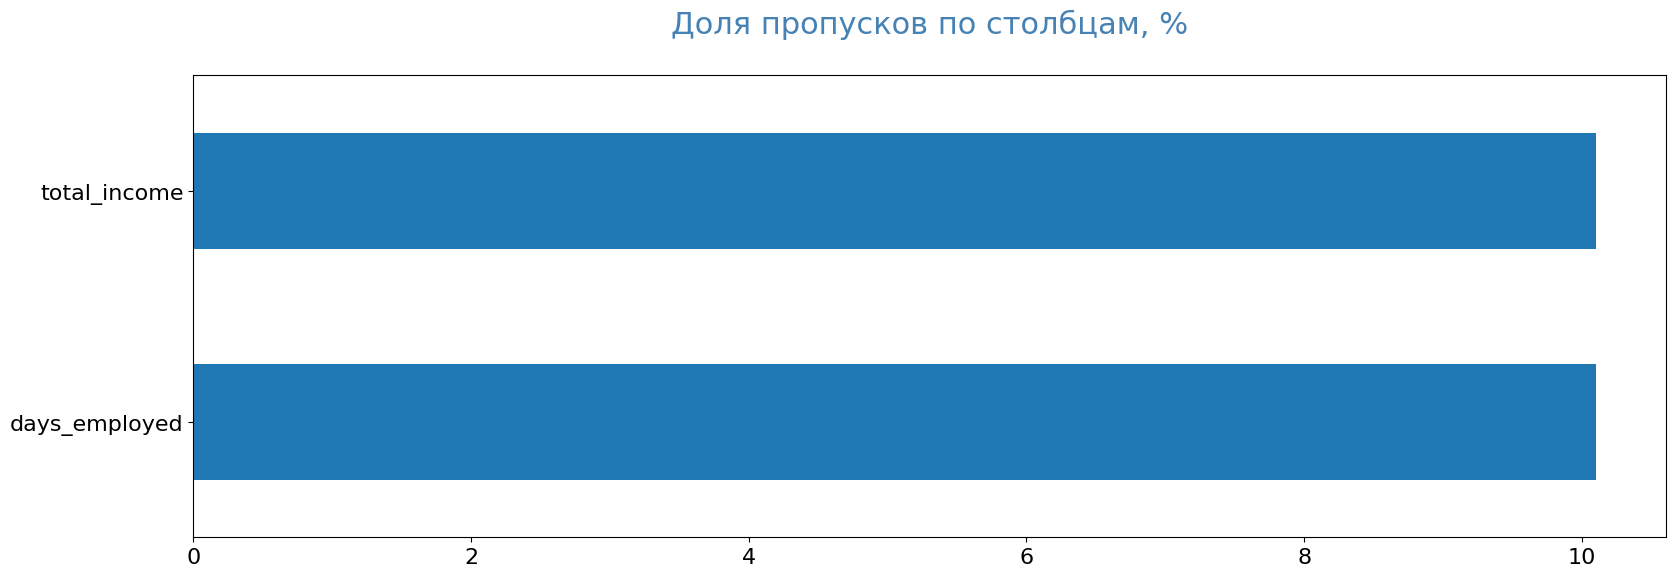

In [6]:
pass_value_barh(data)

Посмотрим на распределения параметров с пропусками

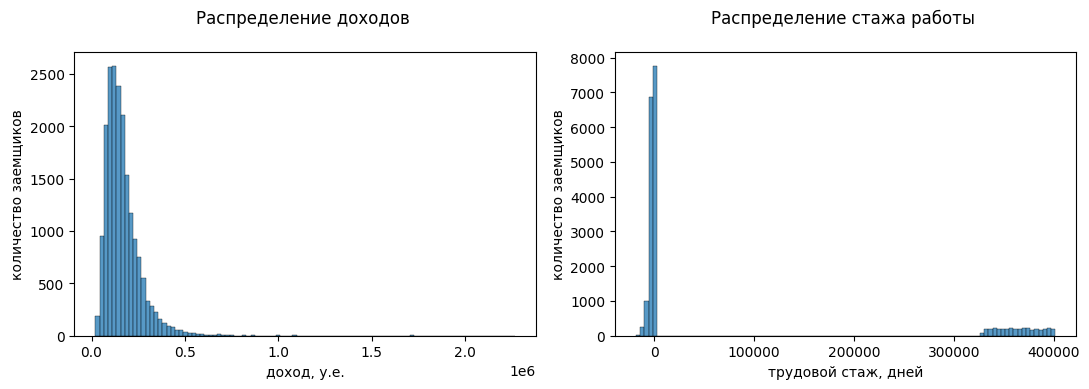

In [7]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11, 4)
fig.set(tight_layout=True)

sns.histplot(data=data, x='total_income', ax=ax[0], bins=100);
sns.histplot(data=data, x='days_employed', ax=ax[1], bins=100);

ax[0].set(ylabel='количество заемщиков', xlabel='доход, у.е.', title='Распределение доходов \n');
ax[1].set(ylabel='количество заемщиков', xlabel='трудовой стаж, дней', title='Распределение стажа работы \n');

- Заполним пропуски в обоих столбцах медианным значением с группировкой по показателю типа занятости 
- В стаже работы встречаются значения меньше нуля, необходимо предварительно сделать их положительными, т.к. стаж -- натуральное число

In [8]:
data['days_employed'] = data['days_employed'].abs()

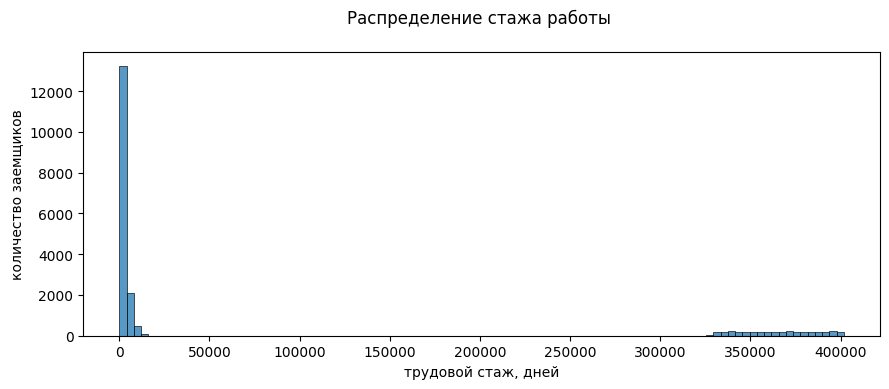

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
fig.set(tight_layout=True)

sns.histplot(data=data, x='days_employed', ax=ax, bins=100);
ax.set(ylabel='количество заемщиков', xlabel='трудовой стаж, дней', title='Распределение стажа работы \n');

Теперь можем произвести замену; напишем функцию:

In [10]:
def missing_values_median_filling(df, column):
    
    missing_types = df[df[column].isna() == 1]['income_type'].unique()
    medians = []

    for i in missing_types:
        medians.append(df[(df[column].isna() == 0) & (df['income_type'] == i)][column].median())
          

    for i in range(len(missing_types)):
        df.loc[df.loc[:, 'income_type'] == missing_types[i], column] = df[column].fillna(medians[i])  

In [11]:
missing_values_median_filling(data, 'total_income')
missing_values_median_filling(data, 'days_employed')

пропусков не осталось :) 


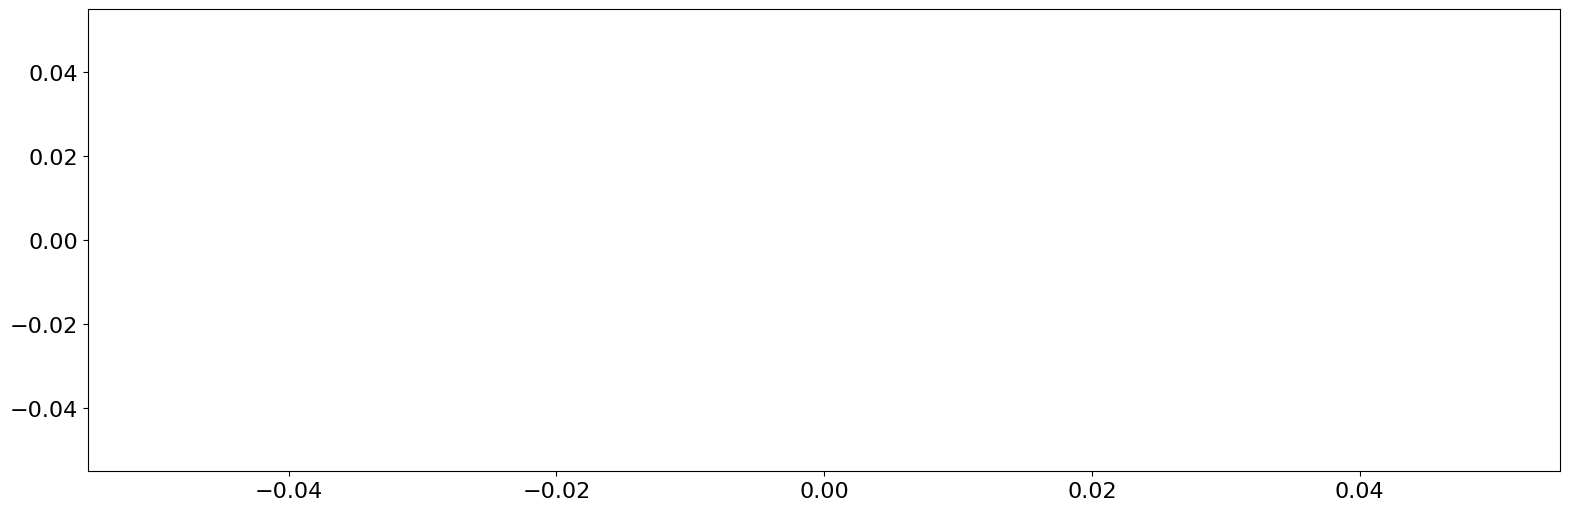

In [12]:
pass_value_barh(data)

От пропусков избавились, посмотрим на итоговые распределения

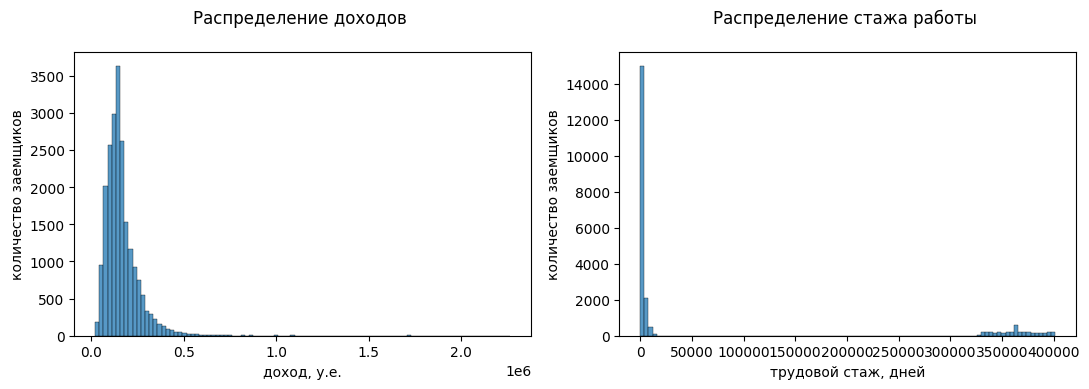

In [13]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11, 4)
fig.set(tight_layout=True)

sns.histplot(data=data, x='total_income', ax=ax[0], bins=100);
sns.histplot(data=data, x='days_employed', ax=ax[1], bins=100);

ax[0].set(ylabel='количество заемщиков', xlabel='доход, у.е.', title='Распределение доходов \n');
ax[1].set(ylabel='количество заемщиков', xlabel='трудовой стаж, дней', title='Распределение стажа работы \n');

Драматического изменения распределений не произошло, оставляем в таком виде

**Вывод**


- Пропуски в исходных данных были в двух столбцах: суммарный опыт работы и суммарный доход
- Все пропуски происходили в обоих столбцах синхронно, можно сделать вывод о связи этих пропусков
    - Вероятно, определенные значения опыта работы приводят к обнулению значения дохода, либо наоборот
    - Наличие пропуска не коррелирует со значениями в других столбцах
- Кроме технических ошибок может влиять человеческий фактор: возможно, некоторые заемщики не указали пропущенные данные при анкетировании
    - Может быть, сотрудник, проверяющий анкеты, пропустил эти пропуски
    - Можно предположить, что это особенная (по каким-то причинам) категория заемщиков, она хранилась в отдельном месте, а при выгрузке данных этот момент не учел специалист, который эту выгрузку делал
- Все пропуски заполнены медианным значением с группировкой по типу занятости

### Аномалии

Визуализируем все показатели, чтобы увидеть странности в распределениях

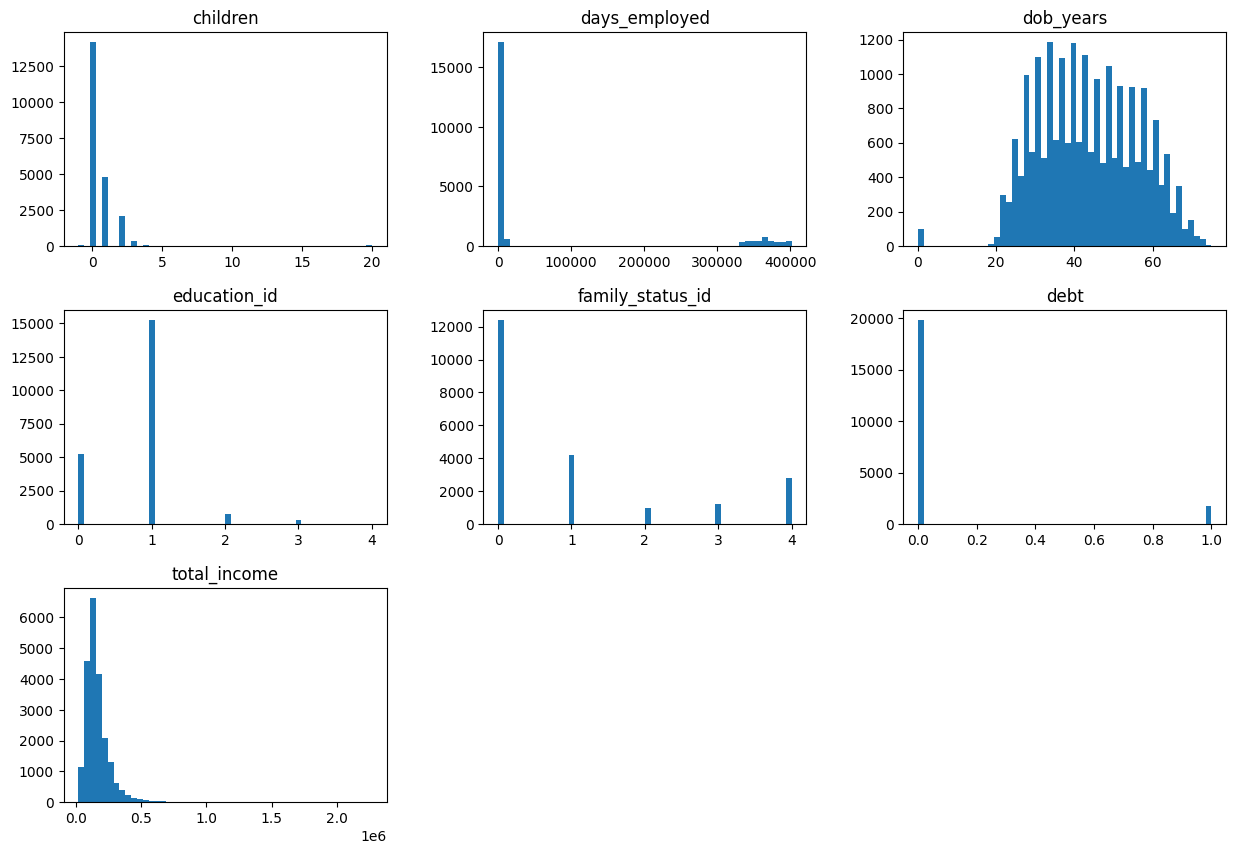

In [14]:
data.hist(figsize=(15, 10), bins=50, grid=False);

В столбце с количеством детей есть отрицательные значения и значения около 20-ти, посмотрим на диаграмме размаха

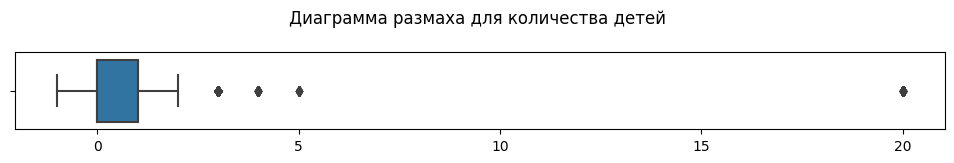

In [15]:
fig, ax = plt.subplots()
fig.set(size_inches=(12, 1))

sns.boxplot(data=data, x='children', ax=ax);
ax.set(xlabel=None, title='Диаграмма размаха для количества детей \n');

In [16]:
data.children.describe()

count   21,525.00
mean         0.54
std          1.38
min         -1.00
25%          0.00
50%          0.00
75%          1.00
max         20.00
Name: children, dtype: float64

Какую часть датафрейма занимают строки с отрицательным, либо равным 20-ти количеством детей?

In [17]:
print(f'Аномальные строки по количеству детей составляют {data.query("children < 0 or children == 20").shape[0] / data.shape[0]:.1%} от исходного датафрейма')

Аномальные строки по количеству детей составляют 0.6% от исходного датафрейма


Строк очень мало, удалим их

In [18]:
data = data.query('not (children < 0 or children == 20)')

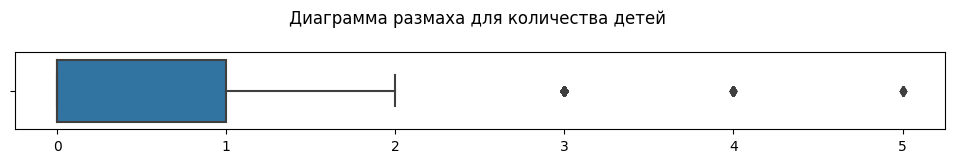

In [19]:
fig, ax = plt.subplots()
fig.set(size_inches=(12, 1))

sns.boxplot(data=data, x='children', ax=ax);
ax.set(xlabel=None, title='Диаграмма размаха для количества детей \n');

### Типы данных

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21402 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21402 non-null  int64  
 1   days_employed     21402 non-null  float64
 2   dob_years         21402 non-null  int64  
 3   education         21402 non-null  object 
 4   education_id      21402 non-null  int64  
 5   family_status     21402 non-null  object 
 6   family_status_id  21402 non-null  int64  
 7   gender            21402 non-null  object 
 8   income_type       21402 non-null  object 
 9   debt              21402 non-null  int64  
 10  total_income      21402 non-null  float64
 11  purpose           21402 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


Приведем столбцы со стажем и доходом к целочисленному типу

In [21]:
data['total_income'] = data['total_income'].astype('int')
data['days_employed'] = data['days_employed'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21402 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21402 non-null  int64 
 1   days_employed     21402 non-null  int64 
 2   dob_years         21402 non-null  int64 
 3   education         21402 non-null  object
 4   education_id      21402 non-null  int64 
 5   family_status     21402 non-null  object
 6   family_status_id  21402 non-null  int64 
 7   gender            21402 non-null  object
 8   income_type       21402 non-null  object
 9   debt              21402 non-null  int64 
 10  total_income      21402 non-null  int64 
 11  purpose           21402 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


### Дубликаты

Проверим наличие неявных дубликатов

In [22]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


In [23]:
def unique_text_values(df):

    for i in ['education', 'family_status', 'gender', 'income_type', 'purpose']:
        print('-' * 70)
        print(i)
        print()
        print(df[i].unique())
    
unique_text_values(data)

----------------------------------------------------------------------
education

['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
----------------------------------------------------------------------
family_status

['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']
----------------------------------------------------------------------
gender

['F' 'M' 'XNA']
----------------------------------------------------------------------
income_type

['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']
----------------------------------------------------------------------
purpose

['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка

- В столбце с образованием есть неявные дубликаты, приведем к нижнему регистру
- В единственном семейном статусе `Не женат / не замужем` встречается верхний регистр, для однообразия не помешает привести к нижнему
- Встречается пол `XNA`, посмотрим подробнее

In [24]:
data.query('gender == "XNA"')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости


Удалим такую запись

In [25]:
data = data.query('not (gender == "XNA") ')

Теперь поработаем с регистром

In [26]:
for i in ['education', 'family_status']:
    data[i] = data[i].str.lower()

In [27]:
unique_text_values(data)

----------------------------------------------------------------------
education

['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']
----------------------------------------------------------------------
family_status

['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'не женат / не замужем']
----------------------------------------------------------------------
gender

['F' 'M']
----------------------------------------------------------------------
income_type

['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']
----------------------------------------------------------------------
purpose

['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 

Проверим наличие полных дубликатов:

In [28]:
data.duplicated().sum()

71

Удалим дубли

In [29]:
data = data.drop_duplicates()
data.duplicated().sum()

0

### Категоризация

#### Доход

Добавим столбец с категорией дохода по следующему принципу:

- 0–30000 -- `E`
- 30001–50000 -- `D`
- 50001–200000 -- `C`
- 200001–1000000 -- `B`
- более 1000000   -- `A`

In [30]:
def categorize_income(val):
    if val >= 0 and val <= 30000:
        return 'E'
    elif val >= 30001 and val <= 50000:
        return 'D'
    elif val >= 50001 and val <= 200000:
        return 'C'
    elif val >= 200001 and val <= 1000000:
        return 'B'
    else: return 'A'
    
data['total_income_category'] = data['total_income'].apply(categorize_income)
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C


#### Цель заема

Создадим новый столбец с категориями цели кредита, выделим четыре категории:

- операции с автомобилем
- операции с недвижимостью
- проведение свадьбы
- получение образования

In [31]:
def categorize_purpose(purp):
    if 'автомоб' in purp:
        return 'операции с автомобилем'
    elif 'жил' in purp or 'недвижим' in purp:
        return 'операции с недвижимостью'
    elif 'свадьб' in purp:
        return 'проведение свадьбы'
    elif 'образов' in purp:
        return 'получение образования'
    
data['purpose_category'] = data['purpose'].apply(categorize_purpose)
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы


### **Вывод**

- Обнаружены синхронные пропуски в столбцах дохожа и трудового стажа
    - Все пропуски заполнены медианным значением с группировкой по типу занятости
- Отрицательные значения стажа сделаны положительными
- Строки с количеством детей `-1` и `20` удалены (0.6 % исходного датафрейма)
- Два столбца приведены к целочисленному типу
- Ликвидированы неявные дубликаты в информации об образовании, связанные с различным регистром
- Удалена 71 строка с полными дубликатами
- Удалена одна запись с полом клиента `XNA`
- Добавлены категории дохода и цели кредита

## Исследовательский анализ

Исследуем влияние различных параметров заемщика на вероятность просрочки кредита

In [32]:
def char_analysis(df, column):
# функция строит сводную таблицу для выбранного параметра, 
# возвращает общее количество заемщиков в категории, вероятность просрочки, долю категории
    pivot_table = (df
                   .groupby(column, 
                            as_index=False)
                   .agg({'total_income':'count', 
                         'debt':'mean'})
                   .rename(columns={'total_income':'total',
                                  'debt':'fail_rate'})
                   .sort_values(by='fail_rate')
                   .reset_index(drop=True))
    pivot_table['fraction'] = pivot_table.total / pivot_table.total.sum() * 100
    pivot_table.fail_rate *= 100 
    
    return(pivot_table)

### Количество детей

In [33]:
children_result = char_analysis(data, 'children')

children_result

,children,total,fail_rate,fraction
0,5,9,0.00,0.04
1,0,14090,7.54,66.06
2,3,330,8.18,1.55
3,1,4808,9.23,22.54
4,2,2052,9.45,9.62
5,4,41,9.76,0.19


Некоторые категории очень малы в сравнении с другими, избавимся от них:

In [34]:
children_result = children_result.query('fraction > 9').reset_index(drop=True)
children_result

,children,total,fail_rate,fraction
0,0,14090,7.54,66.06
1,1,4808,9.23,22.54
2,2,2052,9.45,9.62


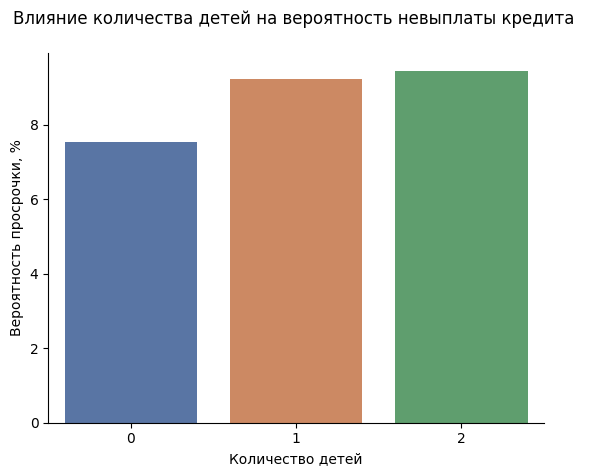

In [35]:
fig, ax = plt.subplots()

sns.barplot(data=children_result, x='children', y='fail_rate', palette='deep')
ax.set(ylabel='Вероятность просрочки, %', 
       xlabel='Количество детей', 
       title='Влияние ' + 'количества детей' + ' на вероятность невыплаты кредита \n')
ax.spines[['top', 'right']].set_visible(False)

plt.show()

- Выборка неоднородна по категории "Количество детей"
    - суммарно категории с количеством детей от 0 до 2-х занимают ~ 98 % исходных данных
    - отбрасываем категории с большим количеством детей как нерепрезентативные
- Данные демонстрируют увеличение риска невыплаты в срок с увеличением количества детей у заемщика, при этом наименее рискованные заемщики -- бездетные люди

### Семейное положение

In [36]:
fam_status_result = char_analysis(data, 'family_status')

fam_status_result

,family_status,total,fail_rate,fraction
0,вдовец / вдова,951,6.62,4.46
1,в разводе,1189,7.06,5.57
2,женат / замужем,12261,7.56,57.48
3,гражданский брак,4133,9.32,19.38
4,не женат / не замужем,2796,9.76,13.11


Категории `вдовец / вдова` и `в разводе` нерепрезентативны, отбрасываем

In [37]:
fam_status_result = fam_status_result.query('fraction > 10').reset_index(drop=True)
fam_status_result

,family_status,total,fail_rate,fraction
0,женат / замужем,12261,7.56,57.48
1,гражданский брак,4133,9.32,19.38
2,не женат / не замужем,2796,9.76,13.11


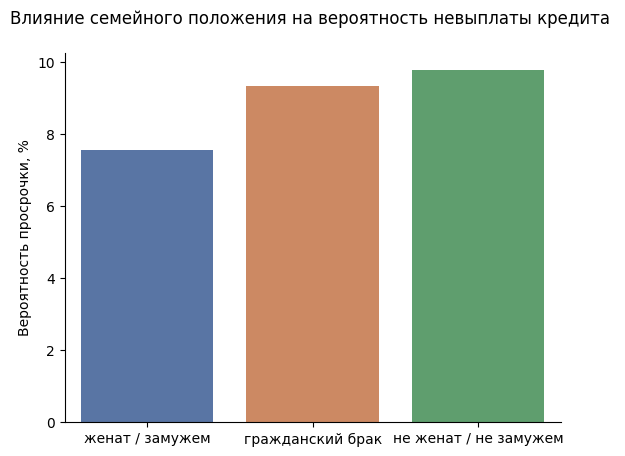

In [38]:
fig, ax = plt.subplots()

sns.barplot(data=fam_status_result, x='family_status', y='fail_rate', palette='deep')
ax.set(ylabel='Вероятность просрочки, %', 
       xlabel=None, 
       title='Влияние ' + 'семейного положения' + ' на вероятность невыплаты кредита \n')
ax.spines[['top', 'right']].set_visible(False)

plt.show()

- Заемщики, находящиеся в зарегистрированном браке, является менее рискованными в сравнении с заемщиками в гражданском браке, которые, в свою очередь, менее рискованные, чем люди не в браке
- С повышением формализованности отношений у заемщика, снижается риск просрочки

### Уровень дохода

In [39]:
income_result = char_analysis(data, 'total_income_category')
income_result

,total_income_category,total,fail_rate,fraction
0,D,349,6.02,1.64
1,B,5013,7.06,23.50
2,A,25,8.00,0.12
3,C,15921,8.50,74.64
4,E,22,9.09,0.10


Отбрасываем категории `D`, `A` и `E` как нерепрезентативные

In [40]:
income_result = income_result.query('fraction > 10').reset_index(drop=True)
income_result

,total_income_category,total,fail_rate,fraction
0,B,5013,7.06,23.50
1,C,15921,8.50,74.64


In [41]:
income_result.loc[0, 'total_income_category'] = 'от 200 тыс. до 1 млн'
income_result.loc[1, 'total_income_category'] = 'от 50 до 200 тыс.'
income_result

,total_income_category,total,fail_rate,fraction
0,от 200 тыс. до 1 млн,5013,7.06,23.50
1,от 50 до 200 тыс.,15921,8.50,74.64


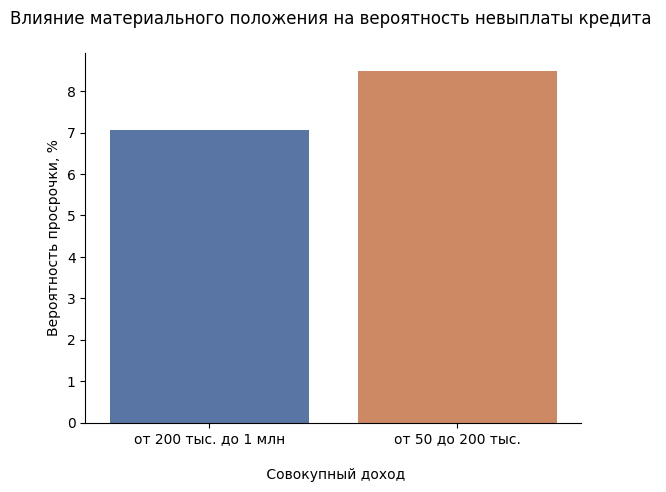

In [42]:
fig, ax = plt.subplots()

sns.barplot(data=income_result, x='total_income_category', y='fail_rate', palette='deep')
ax.set(ylabel='Вероятность просрочки, %', 
       xlabel='\n Совокупный доход', 
       title='Влияние ' + 'материального положения' + ' на вероятность невыплаты кредита \n')
ax.spines[['top', 'right']].set_visible(False)

plt.show()

- С ростом благосостояния снижается средняя вероятность просрочки
- Наименее рискованные заемщики -- наиболее обеспеченные
- Наиболее рискованные -- наименее обеспеченные

### Цель кредита

In [43]:
purpose_result = char_analysis(data, 'purpose_category')
purpose_result

,purpose_category,total,fail_rate,fraction
0,операции с недвижимостью,10750,7.26,50.40
1,проведение свадьбы,2313,7.91,10.84
2,получение образования,3988,9.25,18.70
3,операции с автомобилем,4279,9.35,20.06


Предоставленная выборка данных достаточно однородна по категории "Цель заема", для анализа возьмем все категории

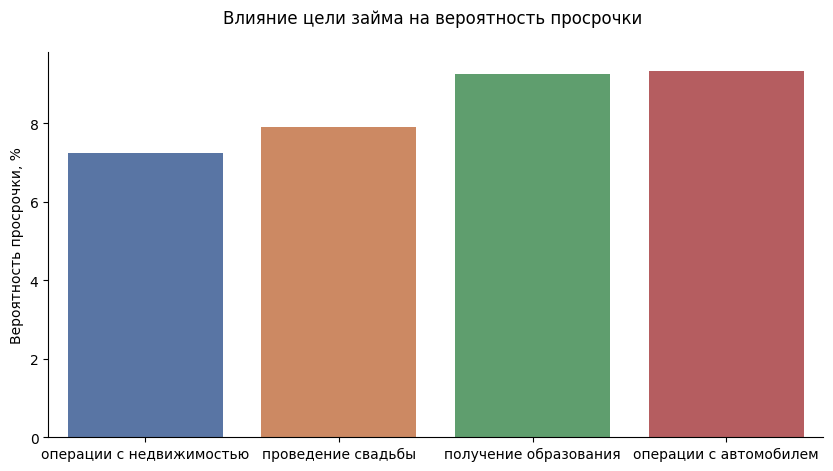

In [44]:
fig, ax = plt.subplots()
fig.set(size_inches=(10, 5))
sns.barplot(data=purpose_result, x='purpose_category', y='fail_rate', palette='deep')
ax.set(ylabel='Вероятность просрочки, %', 
       xlabel=None, 
       title='Влияние ' + 'цели займа' + ' на вероятность просрочки \n')
ax.spines[['top', 'right']].set_visible(False)

plt.show()

- Наименее рискованно одобрять кредит под свадьбу и операции с недвижимостью
- Наиболее рискованные категории -- операции с автомобилем и образование
- Самая рискованная категория -- операции с авто
- Наименее рискованная категория -- операции с недвижимостью

## **Общий вывод**

**Исходные данные**

- Для анализа был использован файл с исходной информацией `data.csv` на 21 тыс. строк


**Предобработка**
- В ходе предобработки данных были обнаружены 2174 одновременно пропущенных значений в столбцах `days_employed` и `total_income`
    - Пропущенные значения заполнены медианным значением заполненных ячеек этих столбцов по категории `income_type`
- Большое количество ячеек столбца `days_employed` имели отрицательное значение, значения взяты по модулю
- Обнаружены два аномальных значения количества детей: -1 и 20, строки с такими значениями удалены
- Тип данных столбца `total_income` и `days_employed` изменен с вещественного на целочисленный
- Категориальные переменные приведены к нижнему регистру
- Строки-дубликаты удалены
    
- Данные по уровню дохода и цели кредита категоризированы
    - Для дохода выделены пять категорий по возрастанию величины 
    - В целях кредита выделены четыре категории: авто, недвижимость, свадьба, образование

**Исследовательский анализ**
- С целью ответа на поставленные вопросы был произведен расчет общего числа заемщиков и общего числа должников по всем категориям в предоставленных данных:

    1) количество детей
    2) семейное положение
    3) уровень дохода
    4) цель кредита


- На основании рассчитанных характеристик была найдена средняя вероятность просрочки кредита для каждой категории каждого атрибута
    - Часть категорий не учитывалась в процессе формирования итогового вывода по причине малого количества записей в выборке
    - Были отброшены следующие категории: 
    
    
        - люди с тремя детьми и более
        - в разводе, вдовцы (вдовы)
        - люди с доходом ниже 50 тыс. и 
        - люди с доходом свыше 1 млн


- Проведенный анализ демонстрирует наличие связи между риском просрочки и количеством детей: чем больше детей, тем выше риск.
    - Наименее рискованная категория -- бездетные люди, наиболее рискованная -- люди с двумя детьми

- Обнаружена связь исследуемого показателя с семейным положением: с ростом обязательств в романтических отношениях надежность заемщика повышается.  
    - Наименее рискованная категория -- люди в браке, наиболее рискованная -- не женатые люди

- Прослеживается связь между уровнем дохода и риском просрочки: чем выше доход, тем ниже вероятность просрочки 
    - Наименее рискованная категория здесь -- люди с доходом от 200 тыс. до 1 млн, а наиболее рискованная -- люди, чем доход составляет от 50 до 200 тыс. 

- Исследование выявило связь между целью заема и вероятностью просрочки: наименее рискованно одобрять кредит под свадьбу и операции с недвижимостью, а наиболее рискованные категории -- операции с автомобилем и образование. 
    - Самая рискованная категория -- операции с авто, наименее рискованная категория -- операции с недвижимостью
    
**Рекомендации**    
- Рекомендуется в системе скоринга учесть атрибуты следующим образом: 
    - увеличение количества детей снижает рейтинг
    - чем более формализованные романтические отношения у человека, тем выше его рейтинг 
    - с ростом дохода рейтинг повышается 
    - для целей кредита предлагается выделить две зоны риска: высокая и низкая
        - к первой категории отнести операции с авто и образование 
        - ко второй -- операции с недвижимостью и свадьбу

- Также рекомендуется изучить причины пропуска ~10 % данных по уровню дохода и суммарному стажу работы
    - Предполагаются технические причины, связанные со сбором, хранением или выгрузкой данных, либо человеческий фактор на этапе сбора 